In [181]:
import os
import cv2
import pandas as pd
import numpy as np
import math
import dlib
import imutils
import random
from PIL import Image
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from skimage import feature
from skimage.feature import hog
from imutils import build_montages
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
from sklearn.svm import LinearSVC
from scipy.stats import ks_2samp
from os import walk

In [183]:
# Nacitanie csv suborov
TruePairs = pd.read_csv("../TruePairs.csv").reset_index()
FalsePairs = pd.read_csv("../FalsePairs.csv").reset_index()

In [184]:
# import the necessary packages
from skimage import feature
import numpy as np
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):

        self.numPoints = numPoints
        self.radius = radius
    def describe(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints,
            self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist


In [185]:
def Average(lst):
    if (len(lst)>0):
        return round((sum(lst) / len(lst)),10)
    else:
        return 0

def getEyes(landmarks2D,i):
    test = []
    test1 = []
    for y in range(36,42,1):
        try:
            eye = landmarks2D[y,:,i]
            test.append(int(eye[0]))
            test1.append(int(eye[1]))
        except:
            pass

    test2 = []
    test3 = []
    for y in range(42,48,1):
        try:
            eye = landmarks2D[y,:,i]
            test2.append(int(eye[0]))
            test3.append(int(eye[1]))
        except:
            pass
    dY = int(Average(test)) - int(Average(test2))
    dX = int(Average(test1)) - int(Average(test3))
    angle = np.degrees(np.arctan2(dX,dY)) - 180
    return angle

# https://datahacker.rs/010-how-to-align-faces-with-opencv-in-python/

def rotateImg (img, landmarks2D,i):
    angle = getEyes(landmarks2D,i)
    h,w = img.shape[:2]
    center = (w // 2, h//2)
    M = cv2.getRotationMatrix2D(center,(angle),1.0)
    rotated = cv2.warpAffine(img,M,(w,h))
    return rotated

In [345]:
# Average Face

# for index, row in TruePairs.iterrows(): #pre vsetky
# Nacitavam udaje, ktore nam boli zadane
desc = LocalBinaryPatterns(24, 8)

print("True pairs:")
distTrue = []
dataAverage = []
labels = []
# for i, row in TruePairs.iloc[:10].iterrows(): #pre prvych desat
for i, row in TruePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load(fileNameA), np.load(fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    averageFaces = np.zeros((96,96,3))
    
# Prechadzam tie prve obrazky
    for i in range(numberOfFramesA):
        img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
        img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(96,96),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (96,96), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare
        
    averageFace = np.float32(averageFaces/numberOfFramesA)
    
    fd, hog_image = hog(averageFace, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist1 = fd
    
    for i in range(numberOfFramesB):
        img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
        img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(96,96),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (96,96), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare
        
    averageFace = np.float32(averageFaces/numberOfFramesB)
    fd, hog_image = hog(averageFace, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist2 = fd
    
    dist = np.linalg.norm(hist1-hist2)
# https://stats.stackexchange.com/questions/211743/how-to-determine-the-similarity-between-histograms
#     dist = ks_2samp(hist1, hist2)[1]
    print(dist)
    
    
    
    distTrue.append(dist)
    dataAverage.append(dist)
    labels.append(1)

    
    
    
    
print("Average: ",Average(distTrue))    
distFalse = []    
print("False pairs:")

# for i, row in FalsePairs.iloc[:10].iterrows(): #pre prvych desat
for i, row in FalsePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load(fileNameA), np.load(fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    averageFaces = np.zeros((96,96,3))
    
# Prechadzam tie prve obrazky
    for i in range(numberOfFramesA):
        img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
        img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(96,96),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (96,96), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare
        
    averageFace = np.float32(averageFaces/numberOfFramesA)
    fd, hog_image = hog(averageFace, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist1 = fd
    
    for i in range(numberOfFramesB):
        img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
        img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(96,96),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (96,96), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare
        
    averageFace = np.float32(averageFaces/numberOfFramesB)
    fd, hog_image = hog(averageFace, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist2 = fd
    
    dist = np.linalg.norm(hist1-hist2)
    distFalse.append(dist)
#     dist = ks_2samp(hist1, hist2)[1]
    
    dataAverage.append(dist)
    labels.append(0)
    print(dist)
print("Average: ",Average(distFalse))    
    

True pairs:
9.957942938099462
6.367613775899477
7.005610777073056
4.010945271935349
10.262494821008655
7.0842183443553965
9.347425909589427
4.03504692127101
8.12414026906769
6.731183220496066
5.078987724367449
7.560403106756776
8.44696776477625
8.655377470443737
9.648815535391421
10.320384117238294
6.28853308362436
5.758463481040665
5.2841792128584455
8.433189842074786
7.404872201808122
8.445139052395433
5.220054208520975
7.771085203067573
6.737326267314508
7.120552690729271
7.940586543811171
3.970950787949523
8.379523626539893
4.206774036449232
5.9226816939133915
6.57040207959881
2.808775751094849
3.771893948109998
7.012431780249116
9.26062274459105
8.96432935195172
4.318494496852744
6.082988183779731
7.078025543763033
5.883051893404106
6.3222137502971245
10.579682020414376
7.38421529840162
9.068914139154908
7.509876256689671
5.7694393106404
8.65412452148603
8.548065982426817
8.648454620170934
7.072464233352696
8.101893992948028
9.2634010787584
6.771852469584099
10.411634254748185
8.5

In [248]:

# data = np.reshape(data,(-1,1))
# X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=0)

# classifier = OneVsRestClassifier(
#     svm.SVC(kernel="linear", probability=True)
# )
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [249]:
# y_pred_proba = classifier.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.plot(fpr,tpr,label="AUC Average="+str((round(auc,2))))
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend(loc=4)
# plt.show()

In [525]:
# Random Face

# for index, row in TruePairs.iterrows(): #pre vsetky
# Nacitavam udaje, ktore nam boli zadane
desc = LocalBinaryPatterns(24, 8)

print("True pairs:")
distTrue = []
dataRandom = []
# for i, row in TruePairs.iloc[:10].iterrows(): #pre prvych desat
for i, row in TruePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load("../" + fileNameA), np.load("../" + fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    
# Prechadzam tie prve obrazky
    i = random.randint(0, numberOfFramesA-1)
    img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
    x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
    img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
    face = img[y:h, x:w] # vyrezem len tvar
    grayFace = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
    
    face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
    
    try:
        os.mkdir("../randomFaces/" + videoNameA[:len(videoNameA) - 6])
    except:
        pass
    cv2.imwrite((str("../randomFaces/" + videoNameA[:len(videoNameA) - 6]) + '/' + videoNameA[:len(videoNameA) - 4]) + '.jpg', face)
    
    fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist1 = fd
    
    i = random.randint(0, numberOfFramesB-1)
    img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
    x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
    img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
    face = img[y:h, x:w] # vyrezem len tvar
    face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
    
    try:
        os.mkdir("../randomFaces/" + videoNameB[:len(videoNameB) - 6])
    except:
        pass
    cv2.imwrite((str("../randomFaces/" + videoNameB[:len(videoNameB) - 6]) + '/' + videoNameB[:len(videoNameB) - 4]) + '.jpg', face)
    
    
    grayFace = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist2 = fd
    
    dist = np.linalg.norm(hist1-hist2)
#     dist = ks_2samp(hist1, hist2)[1]
    distTrue.append(dist)
    dataRandom.append(dist)
    print(dist)
    
    
    
    
print("Average: ",Average(distTrue))    
print("False pairs:")
distFalse = []    

# for i, row in FalsePairs.iloc[:10].iterrows(): #pre prvych desat
for i, row in FalsePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load("../" + fileNameA), np.load("../" + fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    
# Prechadzam tie prve obrazky
    i = random.randint(0, numberOfFramesA-1)
    img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
    x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
    img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
    face = img[y:h, x:w] # vyrezem len tvar
    grayFace = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
    face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
    try:
        os.mkdir("../randomFaces/" + videoNameA[:len(videoNameA) - 6])
    except:
        pass
    cv2.imwrite((str("../randomFaces/" + videoNameA[:len(videoNameA) - 6]) + '/' + videoNameA[:len(videoNameA) - 4]) + '.jpg', face)
    
    fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist1 = fd
    
    i = random.randint(0, numberOfFramesB-1)
    img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
    x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
    img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
    face = img[y:h, x:w] # vyrezem len tvar
    face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
    
    try:
        os.mkdir("../randomFaces/" + videoNameB[:len(videoNameB) - 6])
    except:
        pass
    cv2.imwrite((str("../randomFaces/" + videoNameB[:len(videoNameB) - 6]) + '/' + videoNameB[:len(videoNameB) - 4]) + '.jpg', face)
    
    fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
    hist2 = fd
    
    dist = np.linalg.norm(hist1-hist2)
#     dist = ks_2samp(hist1, hist2)[1]
    distFalse.append(dist)
    dataRandom.append(dist)
    print(dist)
    
print("Average: ",Average(distFalse))    

True pairs:
25.269356813013722
23.62332543927314
21.95538180921366
26.002687489981685
23.647704578124387
24.835496465153962
20.39113259031024
25.72148174690791
25.904730837205477
24.25800346195422
22.241618777763374
23.00917883895773
22.760037132993446
22.87763499419705
22.98314700645892
27.252642571216757
23.817474004233276
19.88038063391215
21.59532348799429
26.92282042725926
24.922601506220335
25.964311350119125
24.549317234448008
24.20711153506219
24.201572122975044
23.51095006094928
25.63180428183248
24.304436471525143
23.559096086939295
22.318519874189736
20.38652997397316
21.692423507003532
19.164646994642908
24.193626321433968
24.016984730731373
25.910208375657078
19.578713080480696
23.413111319093275
23.897419999788344
24.492562385115182
22.16515218348926
24.65074987764036
26.325398982069984
25.25674584076969
25.352526424051156
25.716244020627624
23.31294857777755
25.668918870122145
25.74635674970478
22.85593236664132
21.189472898911287
22.999154520092
23.41383998934944
22.151

In [526]:
# Kazdy s kazdym

# for index, row in TruePairs.iterrows(): #pre vsetky
# Nacitavam udaje, ktore nam boli zadane
desc = LocalBinaryPatterns(24, 8)

print("True pairs:")
distTrue = []
dataEach = []
dataClosest = []
# for i, row in TruePairs.iloc[:10].iterrows(): #pre prvych desat
for q, row in TruePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load("../" + fileNameA), np.load("../" + fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    histA = []
    histB = []
    facesA = []
    facesB = []
    
# Prechadzam tie prve obrazky

    for i in range(numberOfFramesA):
        img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
        img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
        facesA.append(face)
        grayFace = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
        fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        hist1 = fd
        histA.append(hist1)

    
    for i in range(numberOfFramesB):
        img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
        img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
        facesB.append(face)
        fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        hist2 = fd
        histB.append(hist2)
        
    leastA,leastB,minDist = 0,0,999
    distAAverage = []
    for idx, one in enumerate(histA):
        for xdx, second in enumerate(histB):
            dist = np.linalg.norm(one-second)
#             dist = ks_2samp(one, second)[1]
            if(dist<minDist):
                minDist = dist
                leastA = idx
                leastB = xdx
            distAAverage.append(dist)
            
    imageA = cv2.resize(facesA[leastA], (224,224), interpolation = cv2.INTER_AREA)
    imageB = cv2.resize(facesB[leastB], (224,224), interpolation = cv2.INTER_AREA)
    cv2.imwrite(str("../closestFaces/" + videoNameA[:len(videoNameA) - 4]) + '_faces.jpg', imageA)
    cv2.imwrite(str("../closestFaces/" + videoNameB[:len(videoNameB) - 4]) + '_faces.jpg', imageB)
    
    try:
        os.mkdir("../closestFaces/" + videoNameA[:len(videoNameA) - 6])
    except:
        pass
    cv2.imwrite((str("../closestFaces/" + videoNameA[:len(videoNameA) - 6]) + '/' + videoNameA[:len(videoNameA) - 4]) + '.jpg', imageA)
    
    try:
        os.mkdir("../closestFaces/" + videoNameB[:len(videoNameB) - 6])
    except:
        pass
    cv2.imwrite((str("../closestFaces/" + videoNameB[:len(videoNameB) - 6]) + '/' + videoNameB[:len(videoNameB) - 4]) + '.jpg', imageB)
    
    images = np.hstack((imageA,imageB))
    
    cv2.imwrite(str("lookalike/" + videoNameA[:len(videoNameA) - 4]) + '_TruePair.jpg', images)
            
    wantedAverage = Average(distAAverage)
    distTrue.append(wantedAverage)
    dataEach.append(wantedAverage)
    dataClosest.append(minDist)
    print(minDist)

    
       
print("Average: ",Average(distTrue))    
distFalse = []    
print("False pairs:")



# for i, row in FalsePairs.iloc[:10].iterrows(): #pre prvych desat
for q, row in FalsePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load("../" + fileNameA), np.load("../" + fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    histA = []
    histB = []
    facesA = []
    facesB = []
    
# Prechadzam tie prve obrazky

    for i in range(numberOfFramesA):
        img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
        img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
        facesA.append(face)
        fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        hist1 = fd
        histA.append(hist1)

    
    for i in range(numberOfFramesB):
        img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
        img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(224,224),interpolation = cv2.INTER_AREA)
        facesB.append(face)
        fd, hog_image = hog(face, orientations=9, pixels_per_cell=(8, 8),cells_per_block=(2, 2), visualize=True, multichannel=True)
        hist2 = fd
        histB.append(hist2)
        
    leastA,leastB,minDist = 0,0,999
    distAAverage = []
    for idx, one in enumerate(histA):
        for xdx, second in enumerate(histB):
            dist = np.linalg.norm(one-second)
#             dist = ks_2samp(one, second)[1]
            if(dist<minDist):
                minDist = dist
                leastA = idx
                leastB = xdx
            distAAverage.append(dist)
            
    imageA = cv2.resize(facesA[leastA], (224,224), interpolation = cv2.INTER_AREA)
    imageB = cv2.resize(facesB[leastB], (224,224), interpolation = cv2.INTER_AREA)
    cv2.imwrite(str("../closestFaces/" + videoNameA[:len(videoNameA) - 4]) + '_faces.jpg', imageA)
    cv2.imwrite(str("../closestFaces/" + videoNameB[:len(videoNameB) - 4]) + '_faces.jpg', imageB)
    
    try:
        os.mkdir("../closestFaces/" + videoNameA[:len(videoNameA) - 6])
    except:
        pass
    cv2.imwrite((str("../closestFaces/" + videoNameA[:len(videoNameA) - 6]) + '/' + videoNameA[:len(videoNameA) - 4]) + '.jpg', imageA)
    
    try:
        os.mkdir("../closestFaces/" + videoNameB[:len(videoNameB) - 6])
    except:
        pass
    cv2.imwrite((str("../closestFaces/" + videoNameB[:len(videoNameB) - 6]) + '/' + videoNameB[:len(videoNameB) - 4]) + '.jpg', imageB)
    
    images = np.hstack((imageA,imageB))
    
    cv2.imwrite(str("lookalike/" + videoNameA[:len(videoNameA) - 4]) + '_FalsePair.jpg', images)
            
    wantedAverage = Average(distAAverage)
    distFalse.append(wantedAverage)
    print(minDist)
    dataEach.append(wantedAverage)
    dataClosest.append(minDist)

    
    
print("Average: ",Average(distFalse))    
    

True pairs:
20.74998348776469
20.052947511295272
19.372048041090324
21.093222564428586
21.869282314909118
22.925795897452623
19.12597607387047
22.91812988898808
24.68553038333748
19.63273220724658
17.418351822318826
22.425774434995745
21.102063217471933
21.56043999359854
19.741039119864848
25.65889993051152
21.982444699038886
17.590886820971978
19.664569758203957
21.631260890581473
22.217416575498223
24.48837531259111
22.15624062509407
20.294909903357265
23.01968168897616
21.352009225870802
23.54159921101753
23.242198159821523
22.1370675415734
21.02708881895988
18.948460277463976
20.79931655521869
14.213972759575089
22.309138022348638
22.530646109671125
24.51690066985762
17.003438875178368
21.94434307104983
21.698935145375415
23.674243573537208
20.052531304903553
19.89973717736519
24.510182304842687
23.544017991314785
22.26970795663492
24.412679334145793
19.80865687564437
24.54444866421723
23.511576482487747
22.4649599730498
18.503669697712553
21.95288440407694
21.549437897018343
21.25

In [362]:
dataAverage = np.reshape(dataAverage,(-1,1))
dataEach = np.reshape(dataEach,(-1,1))
dataRandom = np.reshape(dataRandom,(-1,1))
dataClosest = np.reshape(dataClosest,(-1,1))

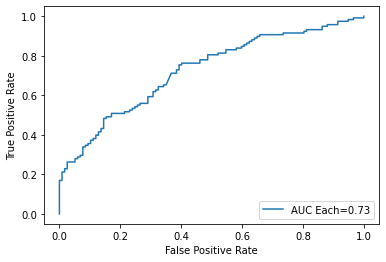

In [360]:
# X_train, X_test, y_train, y_test = train_test_split(dataAverage, labels, test_size=0.5, random_state=0)
# classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# y_pred_proba = classifier.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)

# plt.plot(fpr,tpr,label="AUC Average="+str((round(auc,2))))

X_train, X_test, y_train, y_test = train_test_split(dataEach, labels, test_size=0.5, random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC Each="+str((round(auc,2))))

# X_train, X_test, y_train, y_test = train_test_split(dataRandom, labels, test_size=0.5, random_state=0)
# classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# y_pred_proba = classifier.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="AUC Random="+str((round(auc,2))))

# X_train, X_test, y_train, y_test = train_test_split(dataClosest, labels, test_size=0.5, random_state=0)
# classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# y_pred_proba = classifier.predict_proba(X_test)[::,1]
# fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
# auc = metrics.roc_auc_score(y_test, y_pred_proba)
# plt.plot(fpr,tpr,label="AUC Closest="+str((round(auc,2))))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

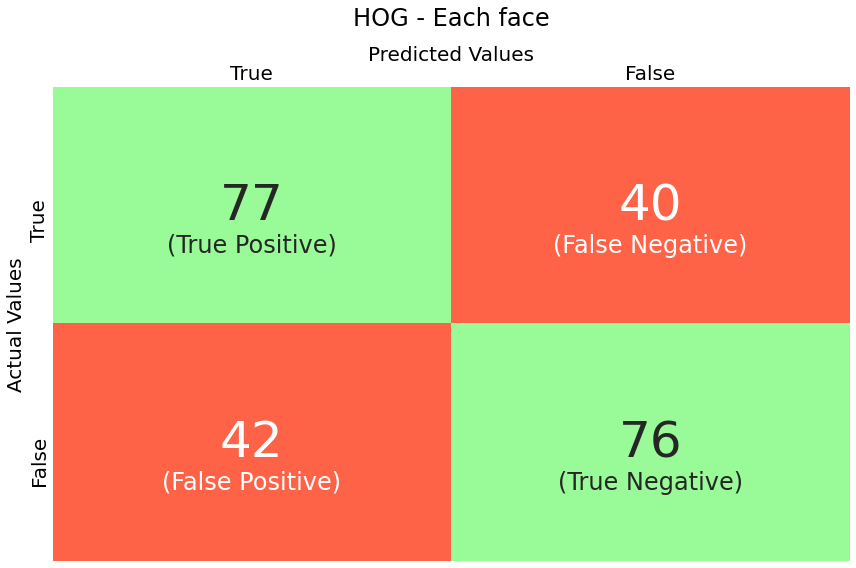

In [361]:
# https://stackoverflow.com/questions/70097754/confusion-matrix-with-different-colors
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted = classifier.predict(X_test)
cfm = confusion_matrix(y_test, predicted)
# sns.heatmap(cfm,annot=True,cmap="Blues")

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(np.eye(2), annot=cfm, fmt='g', annot_kws={'size': 50},
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['True', 'False'], xticklabels=['True', 'False'], ax=ax)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=20, length=0)

ax.set_title('HOG - Each face', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)

additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=24)
plt.tight_layout()
plt.show()

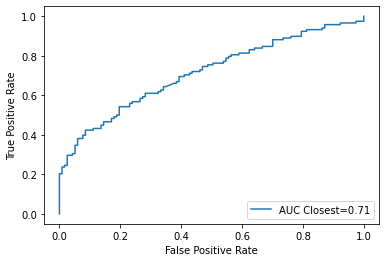

In [363]:
X_train, X_test, y_train, y_test = train_test_split(dataClosest, labels, test_size=0.5, random_state=0)
classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

y_pred_proba = classifier.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC Closest="+str((round(auc,2))))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

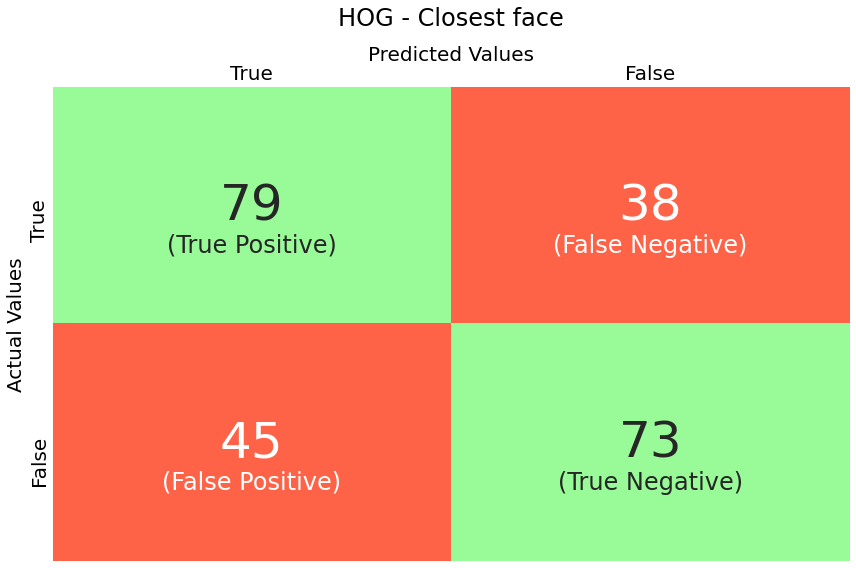

In [364]:
predicted = classifier.predict(X_test)
cfm = confusion_matrix(y_test, predicted)
# sns.heatmap(cfm,annot=True,cmap="Blues")

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(np.eye(2), annot=cfm, fmt='g', annot_kws={'size': 50},
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['True', 'False'], xticklabels=['True', 'False'], ax=ax)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=20, length=0)

ax.set_title('HOG - Closest face', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)

additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=24)
plt.tight_layout()
plt.show()

In [527]:
# BIG GUNS - CNN

averageFacesAll = []
number=0
averageFacesLabels = []
rozmer = 224
# for i, row in TruePairs.iloc[:10].iterrows(): #pre prvych desat
for i, row in TruePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load("../" + fileNameA), np.load("../" + fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    averageFaces = np.zeros((rozmer,rozmer,3))
    
    for i in range(numberOfFramesA):
        img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
        img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(rozmer,rozmer),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (rozmer,rozmer), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare    
    averageFace = np.float32(averageFaces/numberOfFramesA)
    
    averageFacesAll.append(averageFace)
    
#     cv2.imwrite(str("../averageFaces/" + videoNameA[:len(videoNameA) - 4]) + '_faces.jpg', averageFace)

    try:
        os.mkdir("../averageFaces/" + videoNameA[:len(videoNameA) - 6])
    except:
        pass
    cv2.imwrite((str("../averageFaces/" + videoNameA[:len(videoNameA) - 6]) + '/' + videoNameA[:len(videoNameA) - 4]) + '.jpg', averageFace)
                     
    averageFacesLabels.append(number)
    averageFaces = np.zeros((rozmer,rozmer,3))
    
    for i in range(numberOfFramesB):
        img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
        img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(rozmer,rozmer),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (rozmer,rozmer), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare  
    averageFace = np.float32(averageFaces/numberOfFramesB)
    averageFacesAll.append(averageFace)
    averageFacesLabels.append(number)
    cv2.imwrite(str("../averageFaces/" + videoNameB[:len(videoNameB) - 4]) + '_faces.jpg', averageFace)
    
    try:
        os.mkdir("../averageFaces/" + videoNameB[:len(videoNameB) - 6])
    except:
        pass
    cv2.imwrite((str("../averageFaces/" + videoNameB[:len(videoNameB) - 6]) + '/' + videoNameB[:len(videoNameB) - 4]) + '.jpg', averageFace)
    
    number+=1


# for i, row in FalsePairs.iloc[:10].iterrows(): #pre prvych desat
for i, row in FalsePairs.iterrows(): #pre vsetky
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    videoFileA, videoFileB = np.load("../" + fileNameA), np.load("../" + fileNameB)
    boundingBoxA, boundingBoxB = videoFileA['boundingBox'], videoFileB['boundingBox']
    colorImagesA, colorImagesB = videoFileA['colorImages'], videoFileB['colorImages']
    landmarks2DA, landmarks2DB = videoFileA['landmarks2D'], videoFileB['landmarks2D']
    numberOfFramesA, numberOfFramesB = colorImagesA.shape[3], colorImagesB.shape[3]
    
    
# Prechadzam tie prve obrazky
    averageFaces = np.zeros((rozmer,rozmer,3))
    for i in range(numberOfFramesA):
        img = cv2.cvtColor(colorImagesA[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxA[0][0][i]),int(boundingBoxA[0][1][i]), int(boundingBoxA[2][0][i]),int(boundingBoxA[3][1][i])
        img = rotateImg(img,landmarks2DA,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(rozmer,rozmer),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (rozmer,rozmer), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare  
    averageFace = np.float32(averageFaces/numberOfFramesA)
    averageFacesAll.append(averageFace)
    cv2.imwrite(str("../averageFaces/" + videoNameA[:len(videoNameA) - 4]) + '_faces.jpg', averageFace)
    try:
        os.mkdir("../averageFaces/" + videoNameA[:len(videoNameA) - 6])
    except:
        pass
    cv2.imwrite((str("../averageFaces/" + videoNameA[:len(videoNameA) - 6]) + '/' + videoNameA[:len(videoNameA) - 4]) + '.jpg', averageFace)
    averageFacesLabels.append(number)
    number+=1
    
    averageFaces = np.zeros((rozmer,rozmer,3))
    for i in range(numberOfFramesB):
        img = cv2.cvtColor(colorImagesB[:, :, :, i],cv2.COLOR_BGR2RGB)
        x,y,w,h = int(boundingBoxB[0][0][i]),int(boundingBoxB[0][1][i]), int(boundingBoxB[2][0][i]),int(boundingBoxB[3][1][i])
        img = rotateImg(img,landmarks2DB,i) # vyrovnam obrazok podla oci
        face = img[y:h, x:w] # vyrezem len tvar
        face = cv2.resize(face,(rozmer,rozmer),interpolation = cv2.INTER_AREA)
        averageFaces += cv2.resize(face, (rozmer,rozmer), interpolation = cv2.INTER_AREA) #taktiez si pridam do priemernej tvare
    averageFace = np.float32(averageFaces/numberOfFramesB)
    cv2.imwrite(str("../averageFaces/" + videoNameB[:len(videoNameB) - 4]) + '_faces.jpg', averageFace)
    
    try:
        os.mkdir("../averageFaces/" + videoNameB[:len(videoNameB) - 6])
    except:
        pass
    cv2.imwrite((str("../averageFaces/" + videoNameB[:len(videoNameB) - 6]) + '/' + videoNameB[:len(videoNameB) - 4]) + '.jpg', averageFace)
    averageFacesAll.append(averageFace)
    averageFacesLabels.append(number)
    number+=1

In [186]:
path = r"C:\Users\David\BIOM\BIOM_Z3\averageFaces"
averageFaces = []
labels = []
os.chdir(path)

with os.scandir(path) as files:
    for file in files:
        averageFaces.append(file.name)
        newName = file.name[:len(file.name)-12]
        labels.append(newName)

In [189]:
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    img = load_img(file, target_size=(rozmer,rozmer))
    img = np.array(img) 
    reshaped_img = img.reshape(1,rozmer,rozmer,3) 
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [190]:
rozmer = 224
data = {}

for face in averageFaces:
    feat = extract_features(face,model)
    data[face] = feat

filenames = np.array(list(data.keys()))
feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)
unique_labels = list(set(labels))

FileNotFoundError: [Errno 2] No such file or directory: '../foo.pdf'

In [433]:
pca = PCA(n_components = 485, random_state=22)
pca.fit(feat)
x = pca.transform(feat)
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 485


In [434]:
kmeans = KMeans(n_clusters=len(unique_labels),n_jobs=5, random_state=22)
kmeans.fit(x)
kmeans.labels_

C:\Users\David\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


array([ 30, 102, 136, 136, 114,   0, 114,  51, 154,   0, 174,  85,  51,
        20,  19,  26,  32, 118,  78,  51,  33,  25,  25, 124,  25, 183,
        65, 106,  10, 170,  70, 104, 114,  69,  87, 107,  60, 114, 164,
        92,  87,  92,  48,  77,  10,  82,  32,  28,  70,  20,  45,   3,
        85, 101,  29, 124, 169,  24,  33,  28,  20,  85,  27, 105, 188,
       188, 157, 163,  74,  74,  88,  65,  19,  53,  23,   5, 114, 168,
        33,  10,  33,  48,  71,  71,  36, 184,   8,  48, 143,  49,  43,
        65,   9,   0,  51, 129,  95,  85,  73, 189, 120,  10, 146,   9,
        70,  20,  37,  20,  51,  51, 170, 133,  85,  48,  70,  75,   7,
       116,  14,  59,  51,  72, 124,  20,   8, 168, 110,  17,  48,  80,
        89,  48,  36,  41,  33, 170,  19,  70,  38, 129, 158, 158,  56,
       145, 130, 175,  38,  85,  98,  70,  15, 121,  32, 182, 144,  44,
        85,  10,  91,  51,  51,  26,  13,  21, 104,  82,  32,  42,  42,
        23,  23,  39,  15,  42, 122,  71, 122,   2, 187,  26, 14

In [435]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [440]:
groups[6]

['Lisa_Leslie_3_faces.jpg',
 'Mark_Cuban_4_faces.jpg',
 'Orlando_Bloom_0_faces.jpg']

In [500]:
import glob

images = [cv2.imread(file) for file in glob.glob('../averageFaces/*.jpg')]
allAverageFaces = np.array(images)
allAverageFaces = allAverageFaces.reshape(allAverageFaces.shape[:-3] + (-1, 3))
allAverageFaces = allAverageFaces[:, :, 0]

images = [cv2.imread(file) for file in glob.glob('../closestFaces/*.jpg')]
allClosestFaces = np.array(images)
allClosestFaces = allClosestFaces.reshape(allClosestFaces.shape[:-3] + (-1, 3))
allClosestFaces = allClosestFaces[:, :, 0]

images = [cv2.imread(file) for file in glob.glob('../randomFaces/*.jpg')]
allRandomFaces = np.array(images)
allRandomFaces = allRandomFaces.reshape(allRandomFaces.shape[:-3] + (-1, 3))
allRandomFaces = allRandomFaces[:, :, 0]



[clustimage] >WARNING> Parameter grayscale is set to True coz you are using method="hog"
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Scaling images..
[clustimage] >INFO> Writing images to tempdir [C:\Users\David\AppData\Local\Temp\tmp3kz9bvu0]
100%|██████████| 485/485 [00:00<00:00, 1034.11it/s]
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 485/485 [00:36<00:00, 13.14it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=485, features=50176
[clustimage] >INFO> Compute embedding using [tsne]
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  5%|▍         | 1/22 [00:00<00:02,  8.20it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


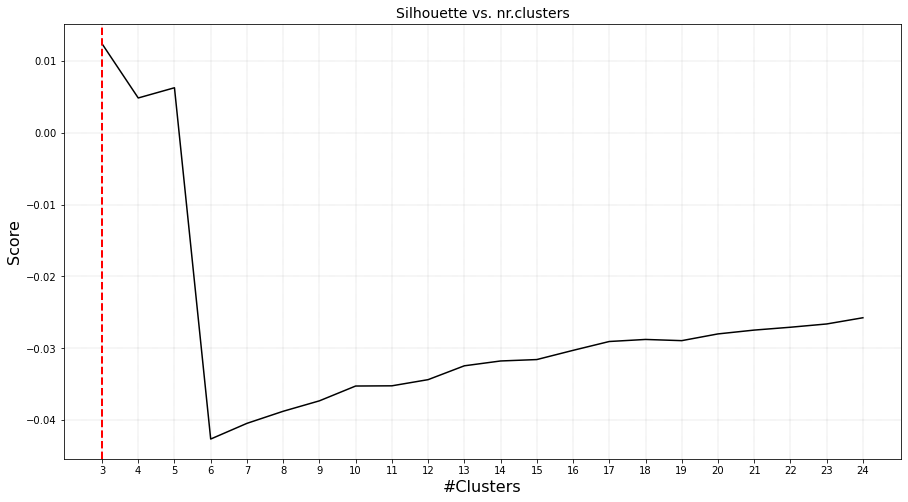

[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  3%|▎         | 1/32 [00:00<00:03,  8.49it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 32/32 [00:03<00:00,  8.27it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  6%|▋         | 1/16 [00:00<00:01,  8.40it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 16/16 [00:01<00:00,  8.25it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [5].
[clusteval] >Fin.


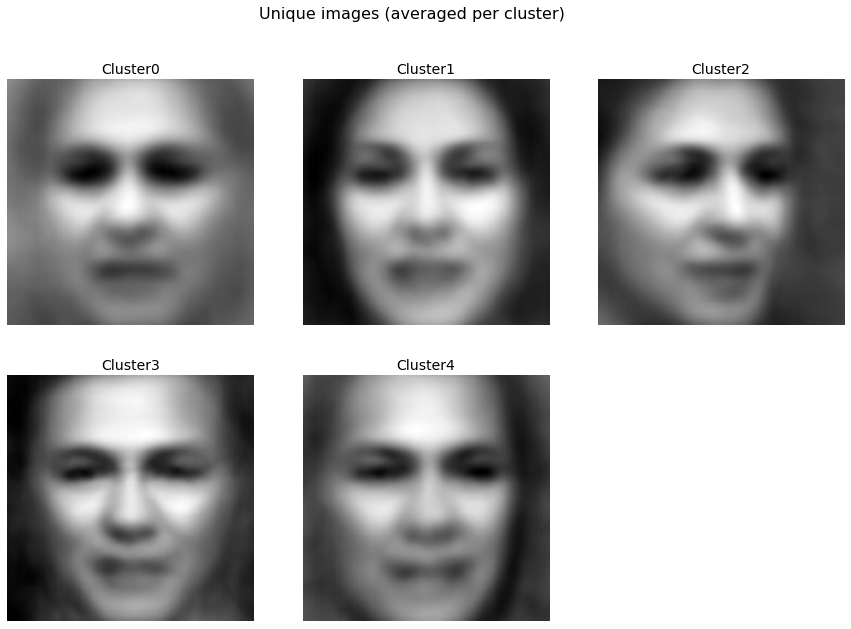

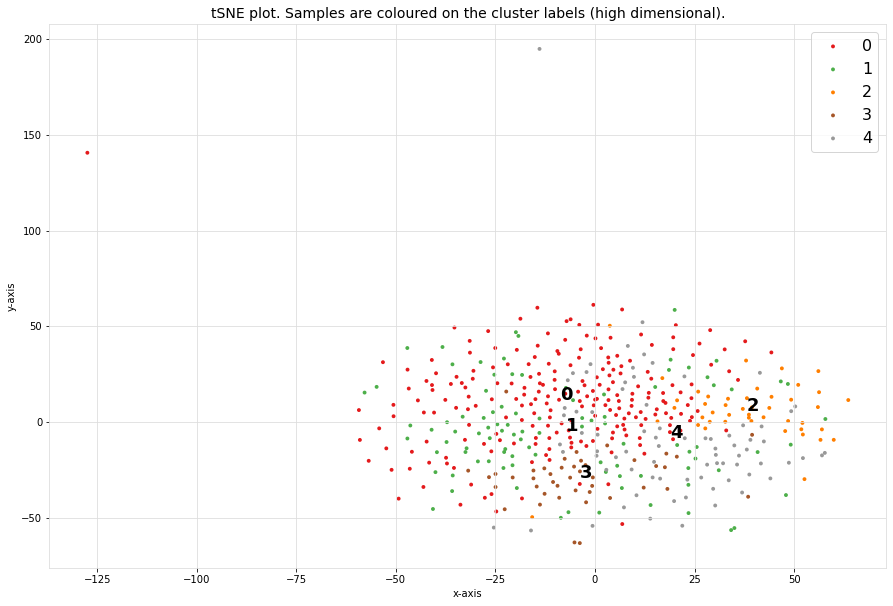

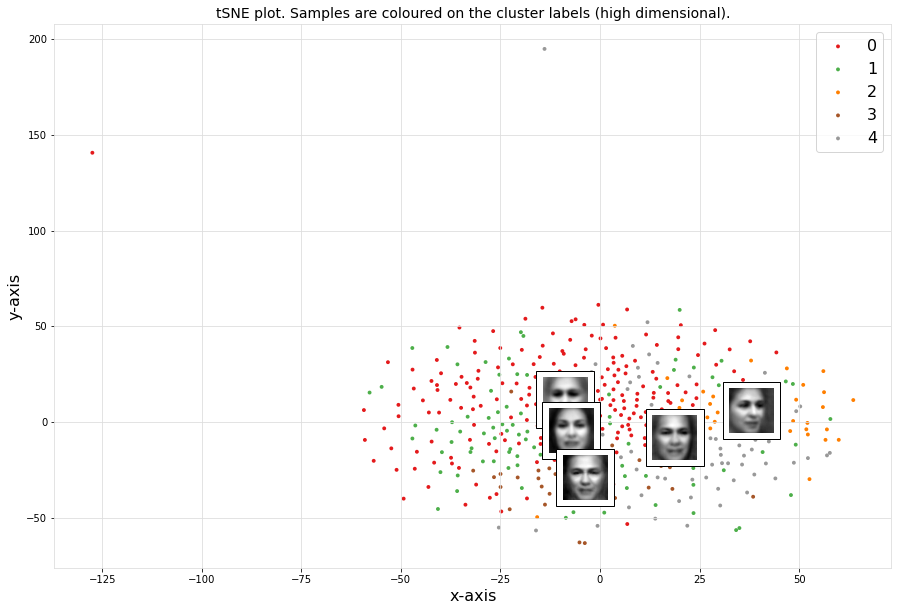

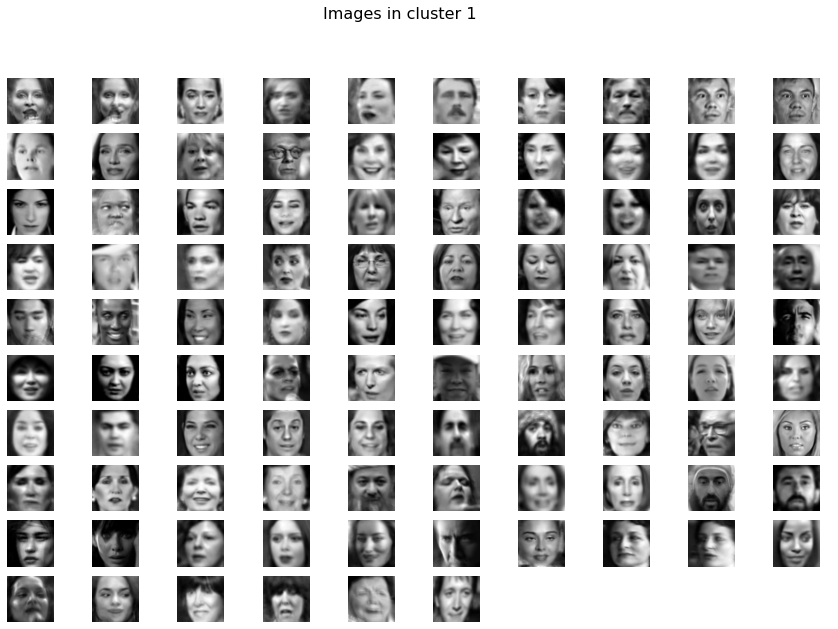

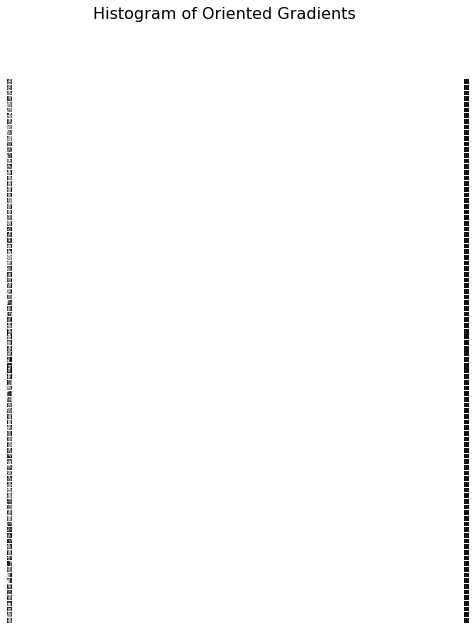

[clustimage] >WARNING> Nothing to plot. First detect faces with ".extract_faces(pathnames)"


[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=1072.979. Be patient now..
[clusteval] >Compute cluster labels.


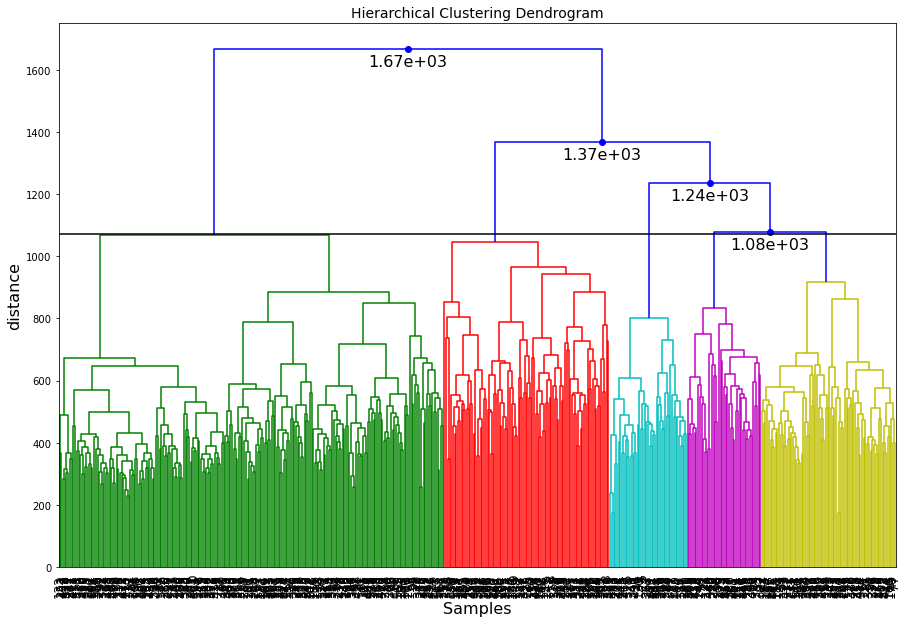

In [501]:
# https://erdogant.github.io/clustimage/pages/html/Examples.html#breaking-up-the-steps
from clustimage import Clustimage
cl = Clustimage(method='hog', grayscale=True)
results = cl.fit_transform(allAverageFaces)
cl.clusteval.plot()
cl.cluster(max_clust=35)
cl.cluster(min_clust=4, max_clust=20)
cl.plot_unique()
cl.scatter(zoom=None)
cl.scatter(zoom=0.2)
cl.plot(show_hog=True, labels=[1,7])
cl.plot_faces()
cl.dendrogram()

[clustimage] >WARNING> Parameter grayscale is set to True coz you are using method="hog"
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Scaling images..
[clustimage] >INFO> Writing images to tempdir [C:\Users\David\AppData\Local\Temp\tmpkveuxwbz]
100%|██████████| 485/485 [00:00<00:00, 995.89it/s] 
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 485/485 [00:37<00:00, 13.01it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=485, features=50176
[clustimage] >INFO> Compute embedding using [tsne]
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  5%|▍         | 1/22 [00:00<00:02,  8.33it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 22/22 [00:02<00:00,  8.28it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [4].
[clusteval] >Fin.


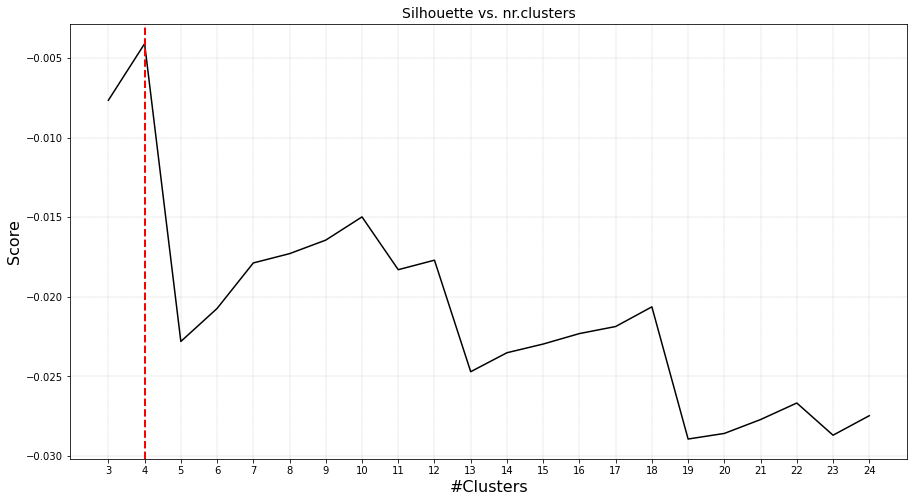

[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  3%|▎         | 1/32 [00:00<00:03,  8.40it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 32/32 [00:03<00:00,  8.27it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [4].
[clusteval] >Fin.


[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  6%|▋         | 1/16 [00:00<00:01,  8.26it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 16/16 [00:01<00:00,  8.17it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [4].
[clusteval] >Fin.


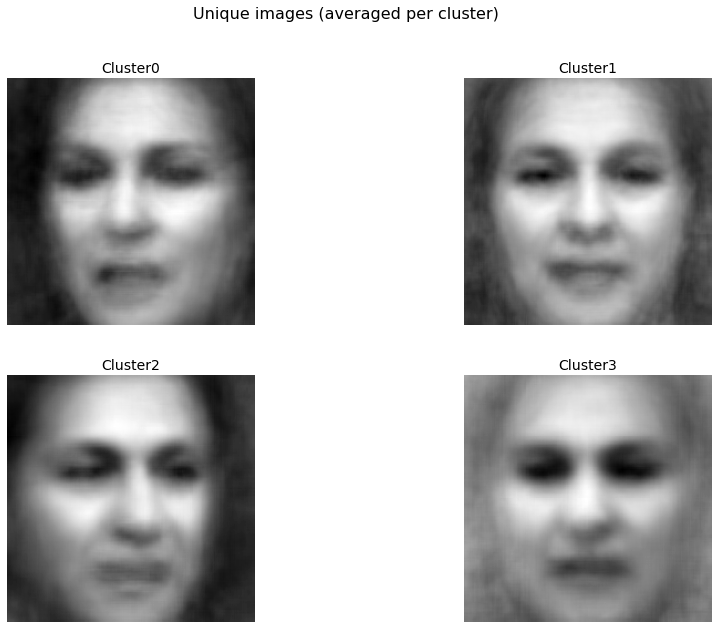

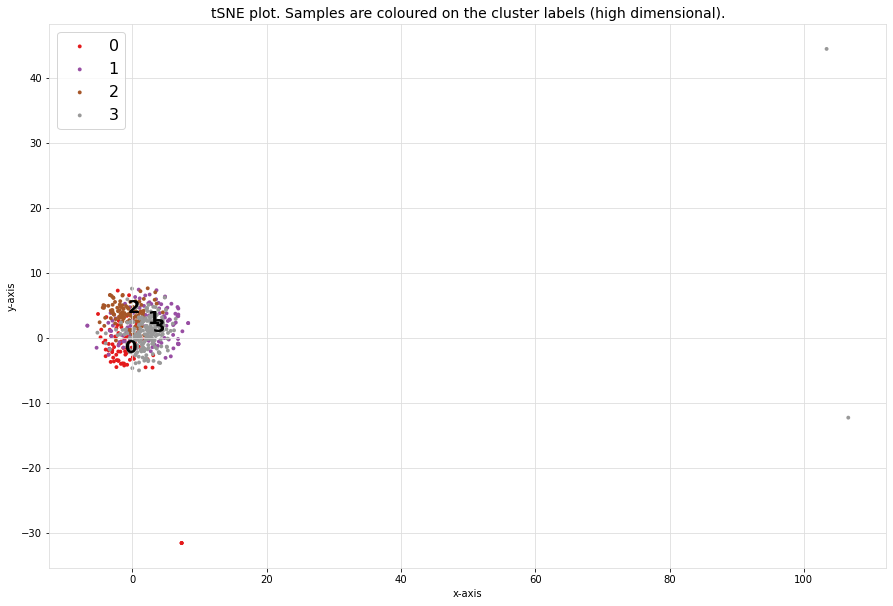

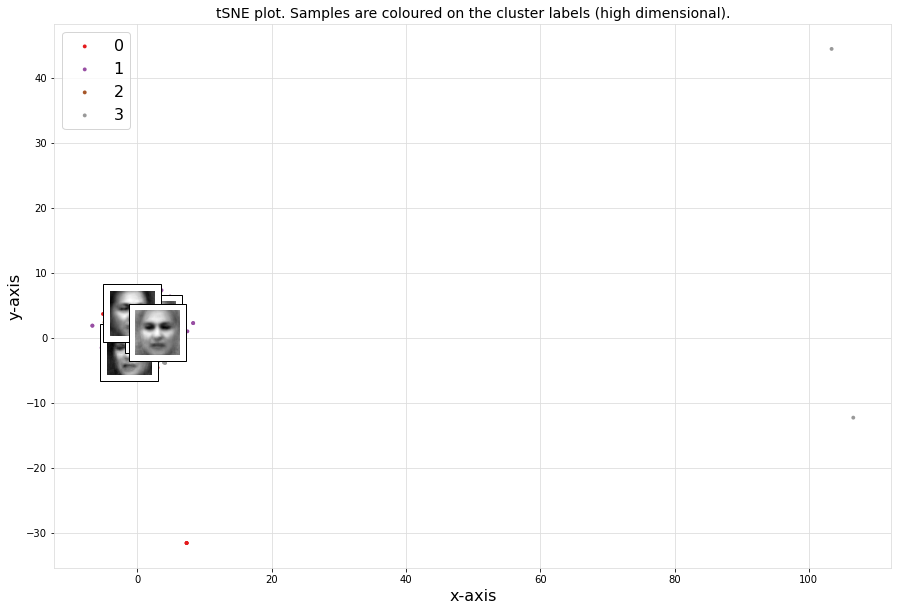

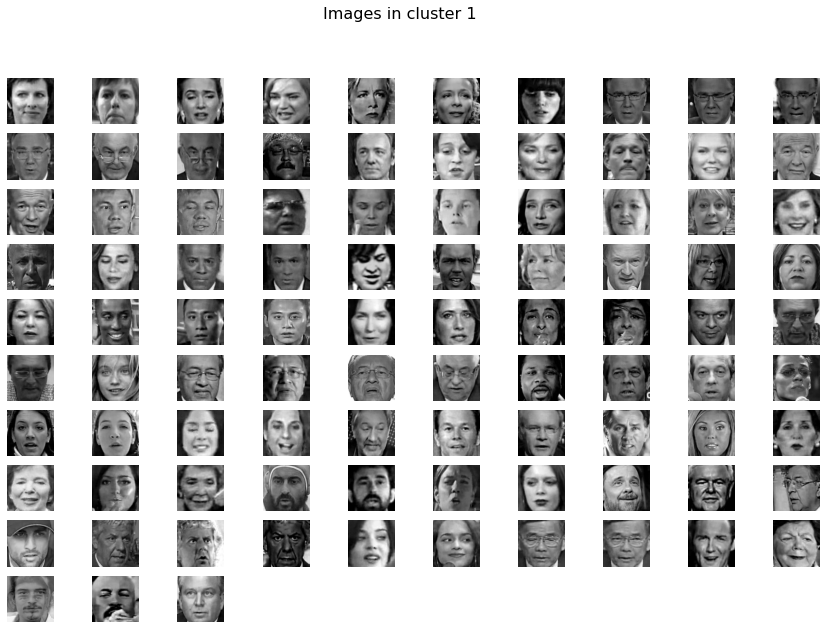

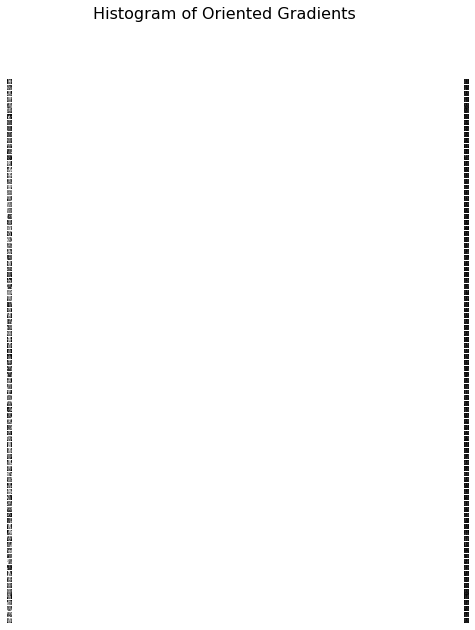

[clustimage] >WARNING> Nothing to plot. First detect faces with ".extract_faces(pathnames)"


[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=1532.527. Be patient now..
[clusteval] >Compute cluster labels.


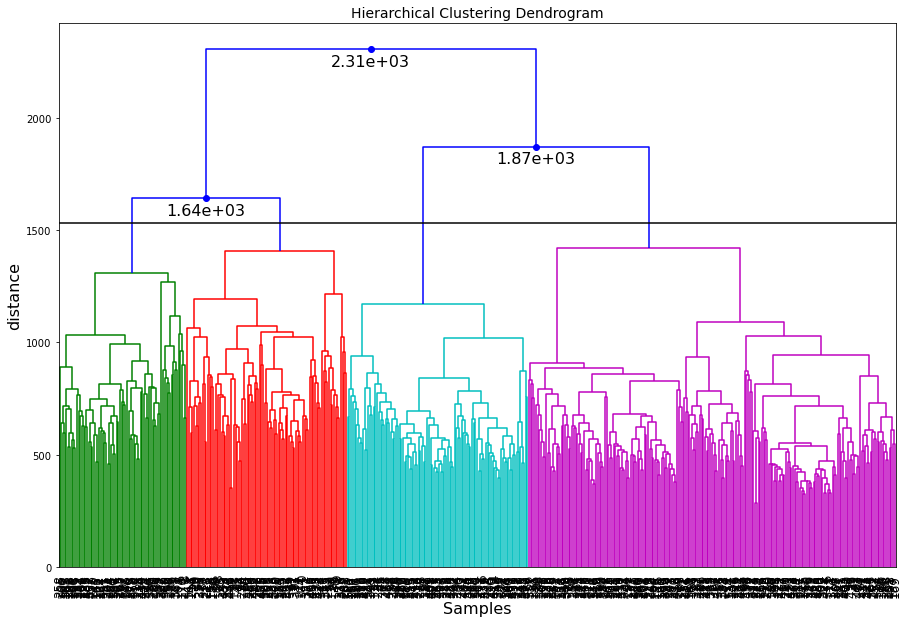

In [502]:
cl = Clustimage(method='hog', grayscale=True)
results = cl.fit_transform(allClosestFaces)
cl.clusteval.plot()
cl.cluster(max_clust=35)
cl.cluster(min_clust=4, max_clust=20)
cl.plot_unique()
cl.scatter(zoom=None)
cl.scatter(zoom=0.2)
cl.plot(show_hog=True, labels=[1,7])
cl.plot_faces()
cl.dendrogram()

[clustimage] >WARNING> Parameter grayscale is set to True coz you are using method="hog"
[clustimage] >INFO> Cleaning previous fitted model results
[clustimage] >INFO> Reading and checking images.
[clustimage] >INFO> Scaling images..
[clustimage] >INFO> Writing images to tempdir [C:\Users\David\AppData\Local\Temp\tmpnqx96rom]
100%|██████████| 485/485 [00:00<00:00, 991.83it/s]
[clustimage] >INFO> Extracting features using method: [hog]
100%|██████████| 485/485 [00:37<00:00, 12.91it/s]
[clustimage] >INFO> Extracted features using [hog]: samples=485, features=50176
[clustimage] >INFO> Compute embedding using [tsne]
[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  5%|▍         | 1/22 [00:00<00:02,  8.33it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 22/22 [00:02<00:00,  8.24it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


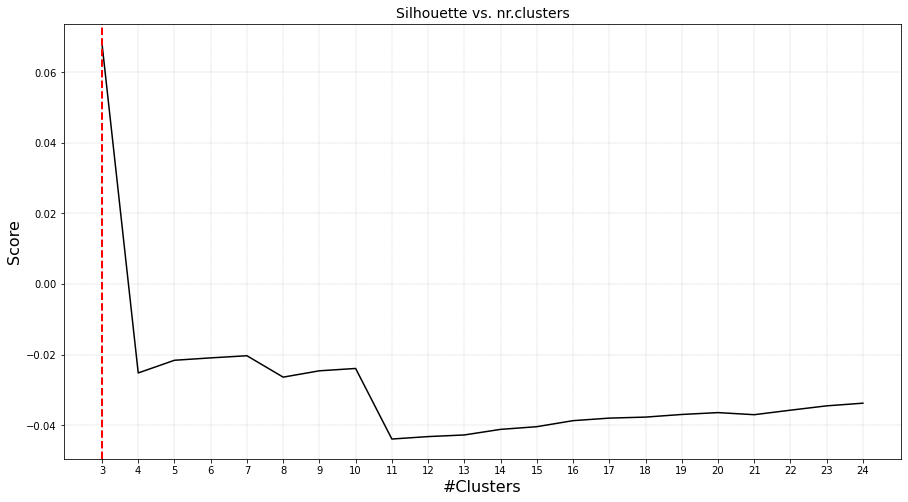

[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  3%|▎         | 1/32 [00:00<00:03,  8.26it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 32/32 [00:03<00:00,  8.10it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [3].
[clusteval] >Fin.


[clustimage] >INFO> Cluster evaluation using the [high] feature space of the [hog] features.



[clusteval] >Fit using agglomerative with metric: euclidean, and linkage: ward


  6%|▋         | 1/16 [00:00<00:01,  8.20it/s]

[clusteval] >Evaluate using silhouette.


100%|██████████| 16/16 [00:01<00:00,  8.20it/s]
[clustimage] >INFO> Updating cluster-labels and cluster-model based on the (485, 50176) feature-space.


[clusteval] >Compute dendrogram threshold.
[clusteval] >Optimal number clusters detected: [7].
[clusteval] >Fin.


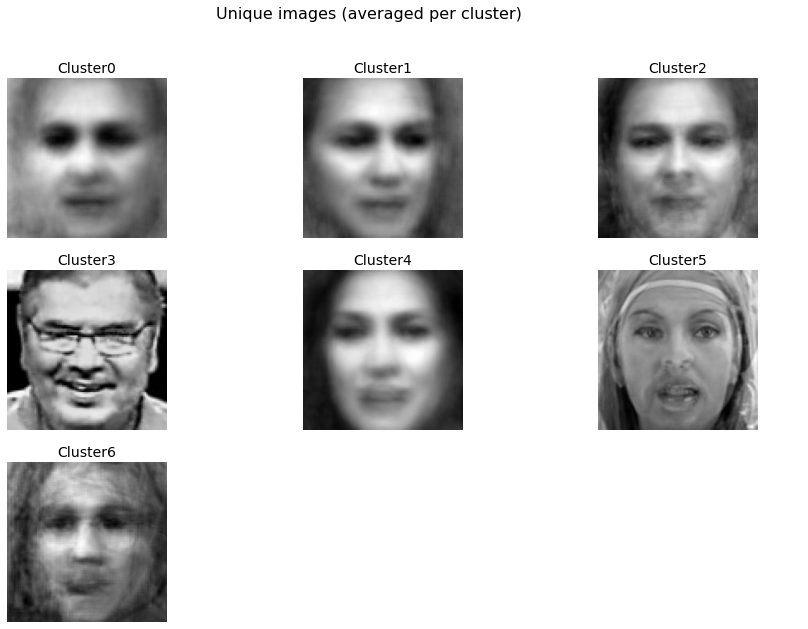

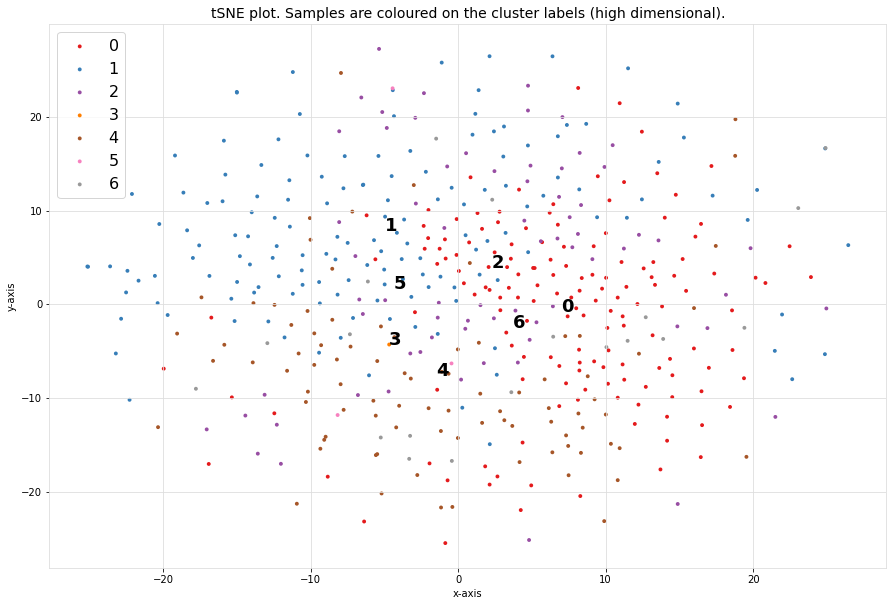

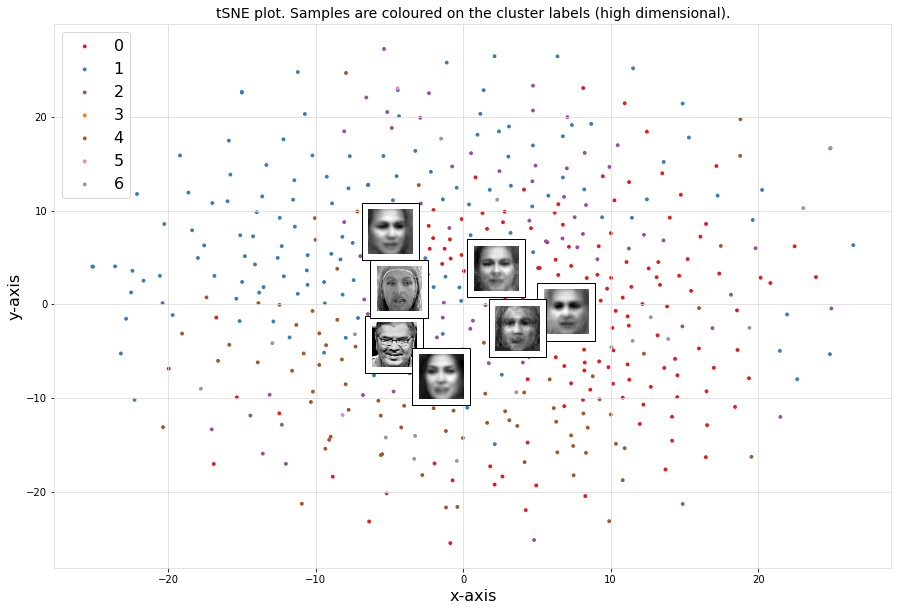

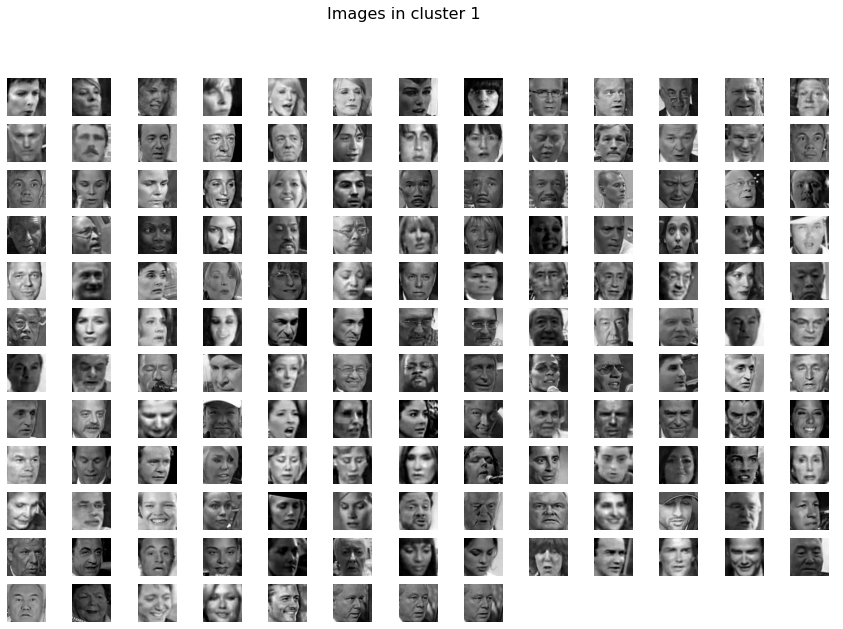

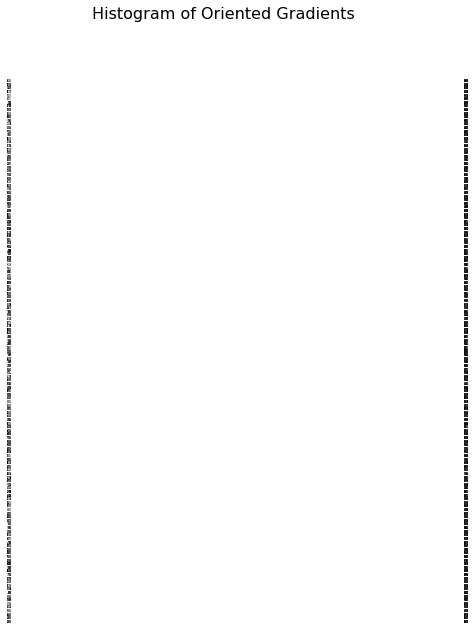

[clustimage] >WARNING> Nothing to plot. First detect faces with ".extract_faces(pathnames)"


[clusteval] >Plotting the dendrogram with optimized settings: metric=euclidean, linkage=ward, max_d=1278.188. Be patient now..
[clusteval] >Compute cluster labels.


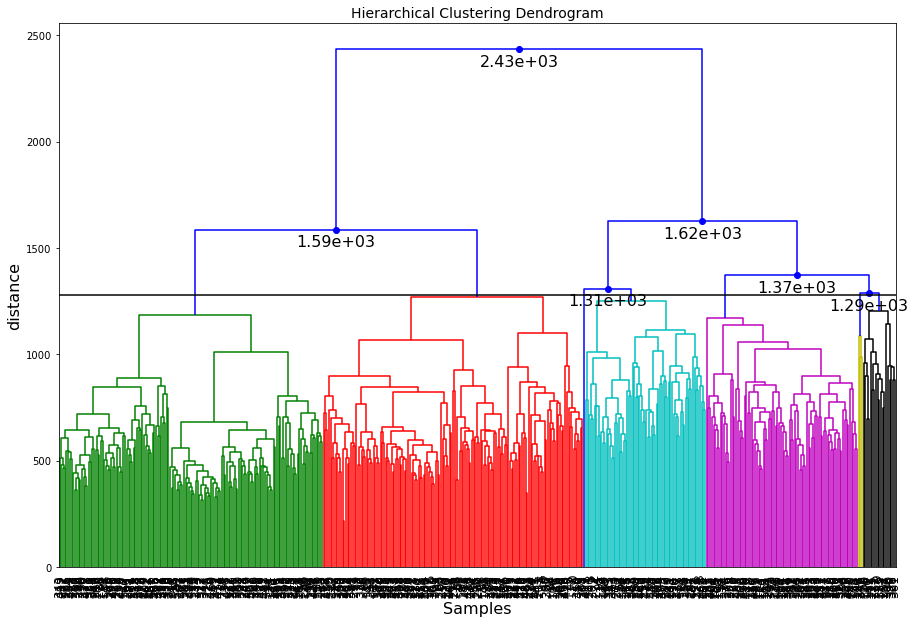

In [503]:
cl = Clustimage(method='hog', grayscale=True)
results = cl.fit_transform(allRandomFaces)
cl.clusteval.plot()
cl.cluster(max_clust=35)
cl.cluster(min_clust=4, max_clust=20)
cl.plot_unique()
cl.scatter(zoom=None)
cl.scatter(zoom=0.2)
cl.plot(show_hog=True, labels=[1,7])
cl.plot_faces()
cl.dendrogram()

In [191]:
# https://thinkingneuron.com/face-recognition-using-deep-learning-cnn-in-python/
batch_size = 16
from keras.preprocessing.image import ImageDataGenerator
TrainingImagePath='/Users/David/BIOM/BIOM_Z3/closestFaces'

train_datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

image_gen_train = ImageDataGenerator(     # here we use the ImageDataGenerator
      rotation_range=40,
      width_shift_range=0.2,                # Applaying these all Data Augmentations
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(128, 128),
        shuffle = True,
        batch_size=batch_size,
        class_mode='categorical')

test_generator = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size=(128, 128),
        shuffle = True,
        batch_size=batch_size,
        class_mode='categorical')

print(test_generator.class_indices)

Found 485 images belonging to 195 classes.
Found 485 images belonging to 195 classes.
{'Karin_Viard': 0, 'Katalin_Kollat': 1, 'Kate_Capshaw': 2, 'Kate_Winslet': 3, 'Katharine_Hepburn': 4, 'Kathryn_Morris': 5, 'Katja_Riemann': 6, 'Keira_Knightley': 7, 'Keith_Olbermann': 8, 'Keith_Tyson': 9, 'Kelsey_Grammer': 10, 'Kemal_Dervis': 11, 'Kenneth_Branagh': 12, 'Kenneth_Carlsen': 13, 'Kenneth_Reichert': 14, 'Kevin_Borseth': 15, 'Kevin_Satterfield': 16, 'Kevin_Spacey': 17, 'Kieran_Culkin': 18, 'Kim_Cattrall': 19, 'Kim_Gandy': 20, 'King_Abdullah_II': 21, 'Kirk_Ferentz': 22, 'Kirsten_Dunst': 23, 'Kit_Bond': 24, 'Kofi_Annan': 25, 'Kostya_Tszyu': 26, 'Krishna_Bhadur_Mahara': 27, 'Kristen_Breitweiser': 28, 'Kristin_Chenoweth': 29, 'Kristin_Scott': 30, 'Kristy_Curry': 31, 'Kurt_Warner': 32, 'Kweisi_Mfume': 33, 'Kyle_Shewfelt': 34, 'Larry_Brown': 35, 'Larry_Flynt': 36, 'Larry_Nichols': 37, 'Larry_Wilmore': 38, 'Laura_Bozzo': 39, 'Laura_Bush': 40, 'Laura_Elena_Harring': 41, 'Laura_Flessel': 42, 'Laura_

In [192]:
TrainClasses=train_generator.class_indices
ResultMap={}
iNeedThis = []
for faceValue,faceName in zip(TrainClasses.values(),TrainClasses.keys()):
    ResultMap[faceValue]=faceName
    iNeedThis.append(faceName)

import pickle
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)
print("Mapping of Face and its ID",ResultMap)
 
# The number of neurons for the output layer is equal to the number of faces
OutputNeurons=len(ResultMap)

print('\n The Number of output neurons: ', OutputNeurons)

Mapping of Face and its ID {0: 'Karin_Viard', 1: 'Katalin_Kollat', 2: 'Kate_Capshaw', 3: 'Kate_Winslet', 4: 'Katharine_Hepburn', 5: 'Kathryn_Morris', 6: 'Katja_Riemann', 7: 'Keira_Knightley', 8: 'Keith_Olbermann', 9: 'Keith_Tyson', 10: 'Kelsey_Grammer', 11: 'Kemal_Dervis', 12: 'Kenneth_Branagh', 13: 'Kenneth_Carlsen', 14: 'Kenneth_Reichert', 15: 'Kevin_Borseth', 16: 'Kevin_Satterfield', 17: 'Kevin_Spacey', 18: 'Kieran_Culkin', 19: 'Kim_Cattrall', 20: 'Kim_Gandy', 21: 'King_Abdullah_II', 22: 'Kirk_Ferentz', 23: 'Kirsten_Dunst', 24: 'Kit_Bond', 25: 'Kofi_Annan', 26: 'Kostya_Tszyu', 27: 'Krishna_Bhadur_Mahara', 28: 'Kristen_Breitweiser', 29: 'Kristin_Chenoweth', 30: 'Kristin_Scott', 31: 'Kristy_Curry', 32: 'Kurt_Warner', 33: 'Kweisi_Mfume', 34: 'Kyle_Shewfelt', 35: 'Larry_Brown', 36: 'Larry_Flynt', 37: 'Larry_Nichols', 38: 'Larry_Wilmore', 39: 'Laura_Bozzo', 40: 'Laura_Bush', 41: 'Laura_Elena_Harring', 42: 'Laura_Flessel', 43: 'Laura_Linney', 44: 'Laura_Pausini', 45: 'Lauren_Hutton', 46: 

In [193]:
# ZDROJ = SUNS
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.models import Sequential
from keras.regularizers import l1,l2
from keras.utils import losses_utils
from keras.utils import tf_utils

baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(128, 128, 3)))
print("[INFO] summary for base model...")
print(baseModel.summary())
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(OutputNeurons, activation="softmax")(headModel)
model = Model(inputs = baseModel.input, outputs = headModel)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), metrics = ['accuracy'])

[INFO] summary for base model...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)  

In [19]:
import datetime
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
log_dir = "logs/test/" + datetime.datetime.now().strftime("%Y%m%d.%H%M%S")

prve = []
druhe = []

class PredictionCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        y_true = []
        y_pred = []
        for i, row in TruePairs.iterrows(): #pre vsetky
            y_true.append(1)
            videoNameA, videoNameB = row['videoA'],row['videoB']
            fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
            fileNameA = fileNameA[:len(fileNameA) - 4] + "_faces.jpg"
            fileNameB = fileNameB[:len(fileNameB) - 4] + "_faces.jpg"

            testImageA = image.load_img(fileNameA, target_size = (128,128))
            testImageA = image.img_to_array(testImageA)
            testImageA=np.expand_dims(testImageA,axis=0)
            resultA=model.predict(testImageA,verbose=0)
            predA = ResultMap[np.argmax(resultA)]

            testImageB = image.load_img(fileNameB, target_size = (128,128))
            testImageB = image.img_to_array(testImageB)
            testImageB=np.expand_dims(testImageB,axis=0)
            resultB=model.predict(testImageB,verbose=0)
            predB = ResultMap[np.argmax(resultB)]

            if predA == predB:
                y_pred.append(1)
            else:
                y_pred.append(0)

        for i, row in FalsePairs.iterrows(): #pre vsetky
            y_true.append(0)
            videoNameA, videoNameB = row['videoA'],row['videoB']
            fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
            fileNameA = fileNameA[:len(fileNameA) - 4] + "_faces.jpg"
            fileNameB = fileNameB[:len(fileNameB) - 4] + "_faces.jpg"

            testImageA = image.load_img(fileNameA, target_size = (128,128))
            testImageA = image.img_to_array(testImageA)
            testImageA=np.expand_dims(testImageA,axis=0)
            resultA=model.predict(testImageA,verbose=0)
            predA = ResultMap[np.argmax(resultA)]

            testImageB = image.load_img(fileNameB, target_size = (128,128))
            testImageB = image.img_to_array(testImageB)
            testImageB=np.expand_dims(testImageB,axis=0)
            resultB=model.predict(testImageB,verbose=0)
            predB = ResultMap[np.argmax(resultB)]

            if predA == predB:
                y_pred.append(1)
            else:
                y_pred.append(0)
        nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_true, y_pred)
        auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
        prve.append(nn_fpr_keras)
        druhe.append(nn_tpr_keras)
        plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
        
        
        

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy'),
    tf.keras.callbacks.ModelCheckpoint(filepath='../models/model.{epoch:02d}-{val_accuracy:.2f}.h5',
                                       save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=10),
#     PredictionCallback(),

]
        


history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=test_generator,
                    validation_steps=STEP_SIZE_TEST,
                    epochs=50,
                    callbacks=my_callbacks
)

C:\Users\David\anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
30/30 [==============================] - 15s 170ms/step - loss: 5.9206 - accuracy: 0.0064 - val_loss: 5.2809 - val_accuracy: 0.0042
Epoch 2/50
30/30 [==============================] - 3s 94ms/step - loss: 5.2744 - accuracy: 0.0064 - val_loss: 5.2661 - val_accuracy: 0.0042
Epoch 3/50
30/30 [==============================] - 3s 94ms/step - loss: 5.2729 - accuracy: 0.0107 - val_loss: 5.2592 - val_accuracy: 0.0063
Epoch 4/50
30/30 [==============================] - 3s 92ms/step - loss: 5.2624 - accuracy: 0.0085 - val_loss: 5.2459 - val_accuracy: 0.0083
Epoch 5/50
30/30 [==============================] - 3s 94ms/step - loss: 5.2480 - accuracy: 0.0043 - val_loss: 5.2211 - val_accuracy: 0.0208
Epoch 6/50
30/30 [==============================] - 3s 93ms/step - loss: 5.2473 - accuracy: 0.0043 - val_loss: 5.2069 - val_accuracy: 0.0104
Epoch 7/50
30/30 [==============================] - 3s 93ms/step - loss: 5.2017 - accuracy: 0.0171 - val_loss: 5.1793 - val_accuracy: 0.0229
Epoch 8/50


In [20]:
pokusA = np.array(prve)
pokusB = np.array(druhe)
resultA = np.mean(pokusA, axis=0)
resultB = np.mean(pokusB, axis=0)

auc_keras = auc(resultA, resultB)
plt.plot(resultA, resultB, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)


C:\Users\David\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\David\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: Singleton array nan cannot be considered a valid collection.

In [32]:
from keras.preprocessing import image 
folderName = '../closestFaces'
data = {}
y_true = []
y_pred = []
allFaceNames = []
for i, row in TruePairs.iterrows(): #pre vsetky
    y_true.append(1)
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    fileNameA = fileNameA[:len(fileNameA) - 4] + "_faces.jpg"
    fileNameB = fileNameB[:len(fileNameB) - 4] + "_faces.jpg"
    allFaceNames.append(fileNameA)
    allFaceNames.append(fileNameB)
    
    testImageA = image.load_img(fileNameA, target_size = (128,128))
    testImageA = image.img_to_array(testImageA)
    testImageA=np.expand_dims(testImageA,axis=0)
    resultA=model.predict(testImageA,verbose=0)
    data[fileNameA] = resultA
    predA = ResultMap[np.argmax(resultA)]
    
    
    
    
    testImageB = image.load_img(fileNameB, target_size = (128,128))
    testImageB = image.img_to_array(testImageB)
    testImageB=np.expand_dims(testImageB,axis=0)
    resultB=model.predict(testImageB,verbose=0)
    data[fileNameB] = resultB
    predB = ResultMap[np.argmax(resultB)]
    
    if predA == predB:
        y_pred.append(1)
    else:
        y_pred.append(0)

for i, row in FalsePairs.iterrows(): #pre vsetky
    y_true.append(0)
    videoNameA, videoNameB = row['videoA'],row['videoB']
    fileNameA, fileNameB = folderName + '/' + videoNameA, folderName + '/' + videoNameB
    fileNameA = fileNameA[:len(fileNameA) - 4] + "_faces.jpg"
    fileNameB = fileNameB[:len(fileNameB) - 4] + "_faces.jpg"
    allFaceNames.append(fileNameA)
    allFaceNames.append(fileNameB)
    
    testImageA = image.load_img(fileNameA, target_size = (128,128))
    testImageA = image.img_to_array(testImageA)
    testImageA=np.expand_dims(testImageA,axis=0)
    resultA=model.predict(testImageA,verbose=0)
    data[fileNameA] = resultA
    predA = ResultMap[np.argmax(resultA)]
    
    testImageB = image.load_img(fileNameB, target_size = (128,128))
    testImageB = image.img_to_array(testImageB)
    testImageB=np.expand_dims(testImageB,axis=0)
    resultB=model.predict(testImageB,verbose=0)
    data[fileNameB] = resultB
    predB = ResultMap[np.argmax(resultB)]
    
    if predA == predB:
        y_pred.append(1)
    else:
        y_pred.append(0)

    
    
#     videoFileA, videoFileB = np.load(fileNameA), np.load(fileNameB)

# y_pred = model.predict(x_test).ravel()

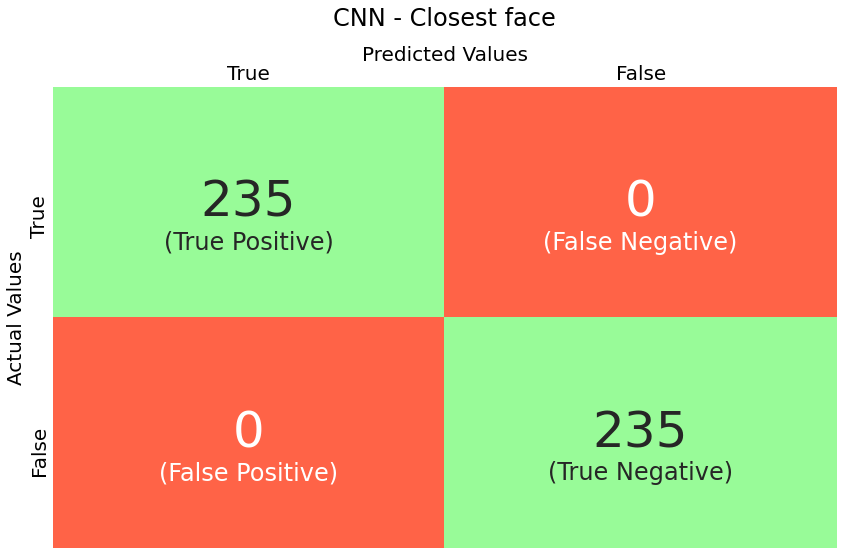

In [625]:
cfm = confusion_matrix(y_true, y_pred)
# sns.heatmap(cfm,annot=True,cmap="Blues")

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(np.eye(2), annot=cfm, fmt='g', annot_kws={'size': 50},
            cmap=sns.color_palette(['tomato', 'palegreen'], as_cmap=True), cbar=False,
            yticklabels=['True', 'False'], xticklabels=['True', 'False'], ax=ax)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.tick_params(labelsize=20, length=0)

ax.set_title('CNN - Closest face', size=24, pad=20)
ax.set_xlabel('Predicted Values', size=20)
ax.set_ylabel('Actual Values', size=20)

additional_texts = ['(True Positive)', '(False Negative)', '(False Positive)', '(True Negative)']
for text_elt, additional_text in zip(ax.texts, additional_texts):
    ax.text(*text_elt.get_position(), '\n' + additional_text, color=text_elt.get_color(),
            ha='center', va='top', size=24)
plt.tight_layout()
plt.show()

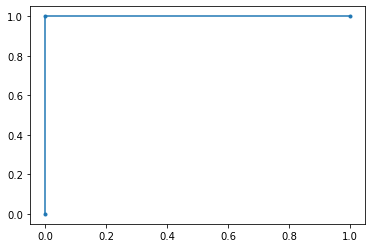

In [22]:
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_true, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [44]:
filenames = np.array(list(data.keys()))
feat = np.array(list(data.values()))
feat = feat.reshape(-1,195)
unique_labels = list(set(iNeedThis))


In [60]:
kmeans = KMeans(n_clusters=len(unique_labels),n_jobs=-1, random_state=22)
kmeans.fit(feat)

C:\Users\David\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=195, n_jobs=-1, random_state=22)

In [61]:
kmeans.labels_

array([187, 187,  68,  68,   2,   2,  25,  25,  46,  46,   8,   8,   8,
        86,  86,  79,  79,  11,  11,  11, 134, 134, 154, 154,  95,  95,
       191, 191, 193, 193,  93,  93, 141, 141,  27,  27,   6,   6,   6,
        34,  34, 180, 180,  17,  17,  17, 118, 118,  13,  13,  13, 165,
       165,   9,   9,   9, 168, 168, 102, 102, 163, 163,  40,  40,  40,
       176, 176,  57,  57,  22,  22, 171, 171,  51,  51,  51,  12,  12,
        12, 185, 185,  92,  92,  98,  98, 101, 101,  20,  20,  32,  32,
        32,  64,  64,  64, 167, 167, 151, 151, 140, 140,  60,  60,  60,
        67,  67, 122, 122,  90,  90, 115, 115, 126, 126, 178, 178, 192,
       192, 111, 111, 177, 177,  72,  72,  47,  47,  94,  94, 133, 133,
        74,  74,  29,  29,  29, 137, 137, 145, 145,  99,  99, 149, 149,
        76,  76,  63,  63,  63,  36,  36,  36,  77,  77,  85,  85,  15,
        15,  15,  41,  41,  41,  38,  38, 181, 181, 131, 131,  97,  97,
       157, 157,  56,  56,  56, 172, 172,  21,  21,  21, 159, 15

In [205]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
groups[134]

['../closestFaces/Marc_Shaiman_3_faces.jpg',
 '../closestFaces/Marc_Shaiman_1_faces.jpg']

In [234]:
kmeans = KMeans(n_clusters = 195)
label = kmeans.fit_predict(feat)
print(label)

[180 180 100 100   9   9  44  44  40  40  21  21  21  92  92  68  68  25
  25  25 131 131 134 134 112 112 192 192  49  49  77  77 151 151  37  37
   6   6   6  34  34 185 185  47  47  47 122 122  72  72  72 170 170   4
   4   4 173 173  86  86 159 159  17  17  17 183 183  43  43  42  42 154
 154  20  20  20  13  13  13 148 148  52  52  81  81  90  90 191 191  28
  28  28  16  16  16 164 164 120 120 133 133  46  46  46  73  73 108 108
 140 140 136 136 127 127 179 179 193 193 118 118 172 172  60  60  54  54
 106 106 111 111  84  84  48  48  48 126 126 132 132 155 155 102 102  62
  62  50  50  50  12  12  12 113 113  69  69  23  23  23  79  79  79  24
  24 158 158 128 128  98  98 156 156  57  57  57 181 181  19  19  19 163
 163 101 101 152 152  14  14 137 137  91  91   2   2   2  66  66  66  39
  39  33  33  56  56 119 119  22  22  97  97  65  65  80  80 149 149 141
 141  35  35  35  64  64 161 161 121 121 109 109  58  58  87  87 139 139
  63  63  63 146 146 117 117  18  18  18  36  36  3

C:\Users\David\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

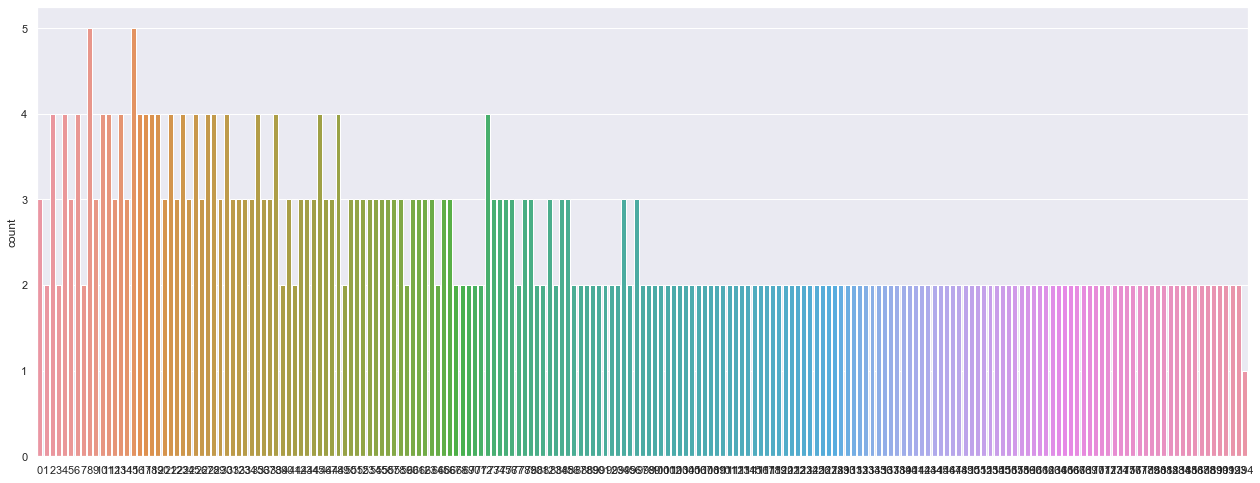

In [268]:
import seaborn as sns
myfigure = sns.set(rc={'figure.figsize':(21.7,8.27)})
sns.countplot(label)
# plt.savefig("clusters.png")

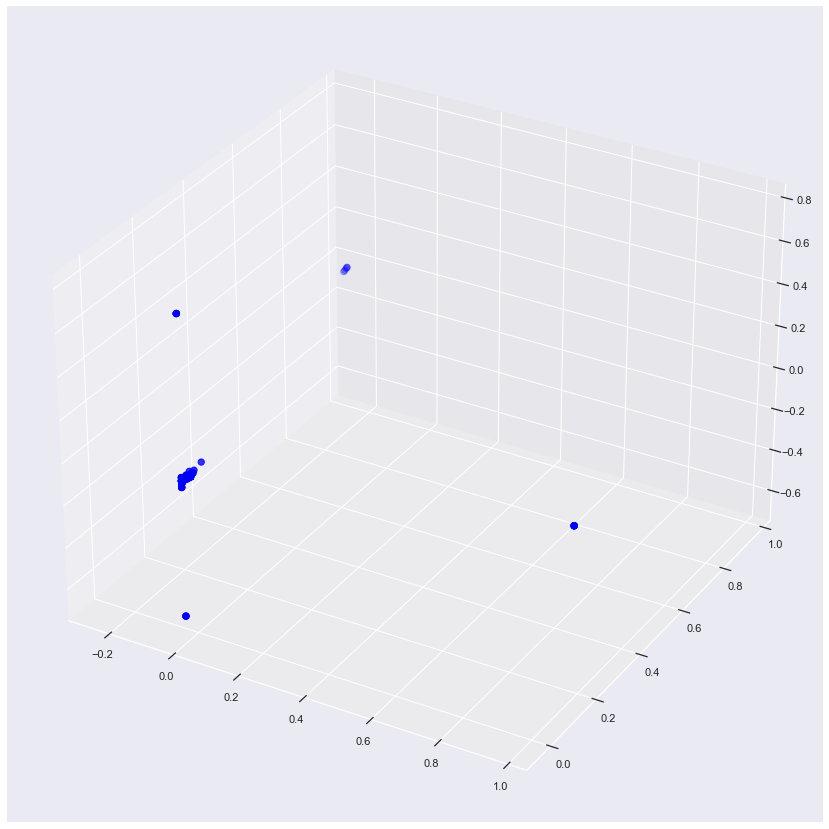

In [267]:
y_clusters = label

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], s = 40 , color = 'blue')
plt.show()


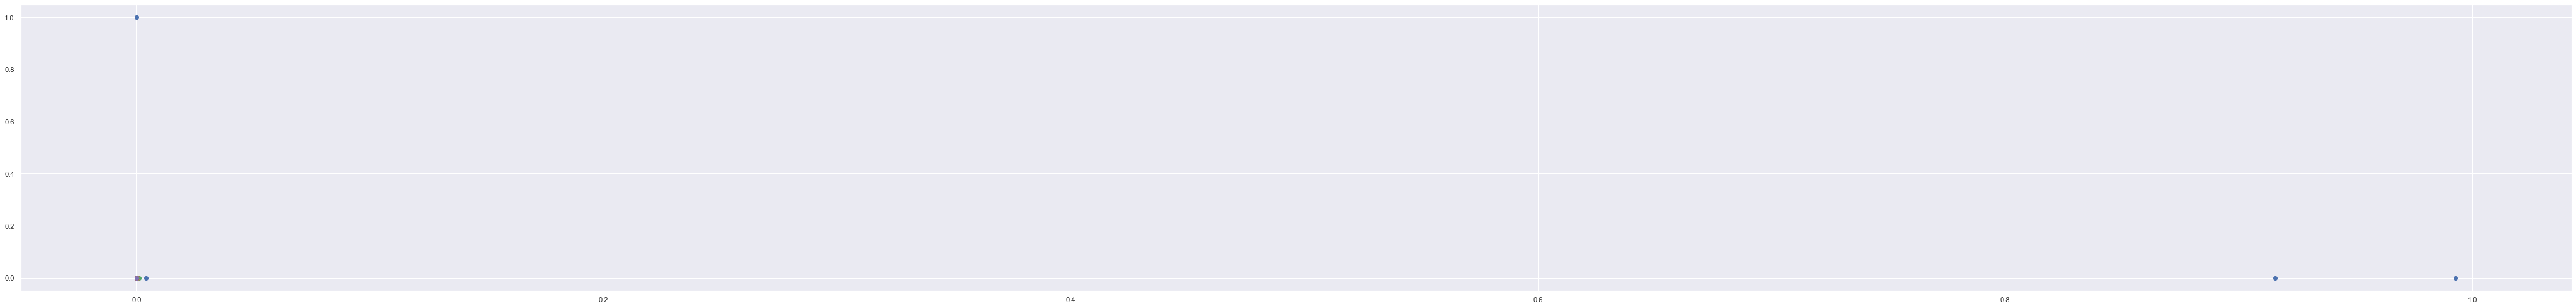

In [254]:
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(feat[label == i , 0] , feat[label == i , 1] , label = i)
# plt.figure(figsize=(30, 30))
# plt.legend()
# plt.xlim(-0.00001,0.00015)
# plt.ylim(-0.00001,0.00015)
# plt.savefig('foo.png', dpi=300)
# plt.savefig('foo.pdf', dpi=300)
plt.show()


In [225]:
type(feat)
np.savetxt("foo.csv", feat, delimiter=",")

In [88]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
groups[1]

['../closestFaces/Mary_Robinson_4_faces.jpg',
 '../closestFaces/Mary_Robinson_2_faces.jpg',
 '../closestFaces/Mary_Robinson_5_faces.jpg',
 '../closestFaces/Mary_Robinson_1_faces.jpg']

In [81]:
centroids = kmeans.cluster_centers_
u_labels = np.unique(label)

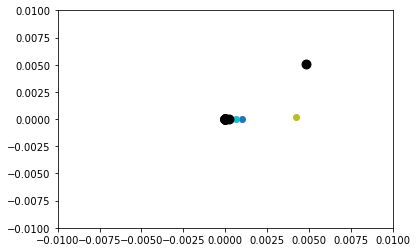

In [100]:
for i in u_labels:
    plt.scatter(feat[label == i , 0] , feat[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
# plt.legend()
plt.xlim(-0.01,0.01)
plt.ylim(-0.01,0.01)
plt.show()